# 0) Imports

In [1]:
import os
import sys
import pdb
import math
import time
import importlib
import umap

from pathlib import Path
import pandas as pd
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import random 

#Custom helper functions:
sys.path.append('./tls')
from funs import tls
from funs import delaunay as delHelpers
from funs import delaunayPlots as delPlots

importlib.reload(delHelpers)
importlib.reload(tls)
results = Path('/mnt/results')

#Original version with 168 TLS detected:
pni = Path('/mnt/results/proc_tma_tls/info/v7.qc0.nr200um.cd20-1000.mincd20-15.ct-14')
pnc = Path('/mnt/results/proc_tma_tls/cell_seg/v7.qc0.nr200um.cd20-1000.mincd20-15.ct-14')
if pni.exists():
    print('Data found')
    
# Version 9 with more stringent cell QC and correct scale factors (50%)
# pni = Path('/mnt/results/proc_tma_tls/cell_seg/v9.qc50.nr400um.cd20-500.mincd20-15.ct-14')
# pnc = Path('/mnt/results/proc_tma_tls/info/v9.qc50.nr400um.cd20-500.mincd20-15.ct-14')

seg_fns= np.sort([fn for fn in pnc.glob('*.tsv')])
tls_info=np.sort([fn for fn in pni.glob('*.json')])
cell_names = ['CD20+',
              'CD4+',
              'CD8+',
              'CD68+',
              'FoxP3+',
              'PanCK+',
              'Tumor',
              'Immune Cell Cluster',
              'AF/Macrophage Cluster']


tissue_types = ['Tumor',
              'Immune Cell Cluster',
              'AF/Macrophage Cluster']

for i,fn in enumerate(tls_info):
    tls_df = pd.read_json(fn)
   
    if tls_df.shape[0] > 2:
        example = i
        break
print('Example: file # %d' % example)
df= pd.read_csv(seg_fns[example],sep='\t')
tls_df=pd.read_json(tls_info[example])
print(df.shape)
print(df.head(2))
notna = ~df['tls_id'].isna().values
print(np.unique(df.loc[notna,'tls_id']))
print('TLS:')
tls_df.head(2)

/opt/conda/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data found
Example: file # 13
(8385, 12)
   Unnamed: 0                                        Sample Name Phenotype  \
0           0  042420  #01 TMA_Phenotyping #1_Core[1,1,R]_[62...     CD20+   
1           1  042420  #01 TMA_Phenotyping #1_Core[1,1,R]_[62...     CD20+   

  Tissue Category  Cell X Position  Cell Y Position Confidence  \
0           Tumor          62893.8           6380.3     87.18%   
1           Tumor          62851.1           6379.8     62.76%   

                                                  fn  tls_id  \
0  /mnt/data/TBruno_TMA_Phenotyping/Cell_segmenta...     1.0   
1  /mnt/data/TBruno_TMA_Phenotyping/Cell_segmenta...     1.0   

   tls_pattern_type  tls_size_type  is_neighbor  
0               NaN            NaN         True  
1               NaN            NaN         True  
[1. 2. 3.]
TLS:


,CD20+,CD4+,CD8+,CD68+,FoxP3+,PanCK+,Others,tls_is_good,n_total,area,tls_coords,xy_center,n_good_tls
0,70,46,2,0,0,10,48,True,176,0.013066,"[[62682, 6379], [62729, 6379], [62753, 6403], ...","[62990.7, 6441.4]",3
1,18,122,20,0,0,31,59,True,250,0.012687,"[[62470, 6595], [62493, 6619], [62493, 6691], ...","[62614.4482758621, 6736.0689655172]",3


In [18]:
np.unique(df.loc[~df['tls_id'].isna(),'tls_id'])


array([1., 2., 3.])

# Debug Delaunay triang on TLS, TLS+Neighbors or just Neighbors:

In [4]:
print(df.columns)

Index(['Unnamed: 0', 'Sample Name', 'Phenotype', 'Tissue Category',
       'Cell X Position', 'Cell Y Position', 'Confidence', 'fn', 'tls_id',
       'tls_pattern_type', 'tls_size_type', 'is_neighbor'],
      dtype='object')


# Note: don't rerun this unless you have a lot of time to kill (see sbatch load below!)

QC threshold: 0, scale_factor: 1, max neighbor dist: 25
Beginning cell connection detection...
0 [62893.8  6380.3] Not found
orig df to cxdf cell map accuracy: 100.0 %
Beginning cell connection detection...
0 [62893.8  6380.3] Not found
152 [62540.8  6491.7] Not found
8327 [62540.8  6491.7] Not found
orig df to cxdf cell map accuracy: 100.0 %
Beginning cell connection detection...
455 [63350.8  6682.1] Not found
orig df to cxdf cell map accuracy: 100.0 %
Finished
191.2766149044037 seconds


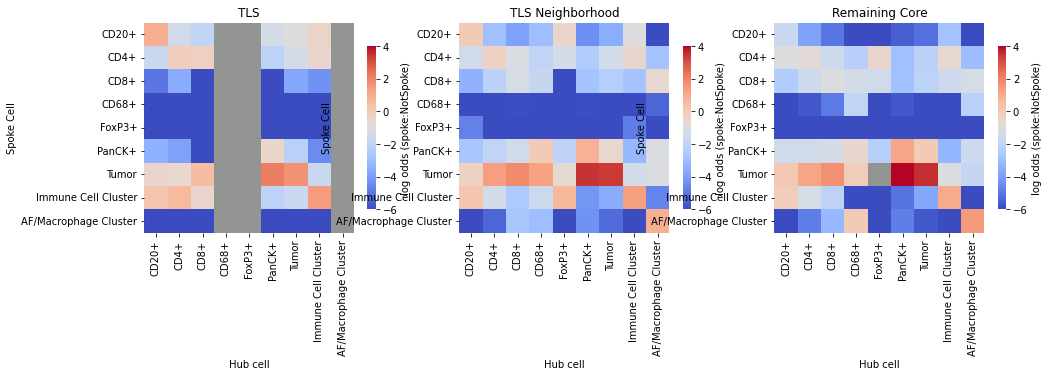

In [5]:
qct = 0
scale = 1
max_dist = 25
print('QC threshold: %d, scale_factor: %d, max neighbor dist: %d' 
        % (qct,scale,max_dist))
qc = tls.get_qc(df,qc_thresh=qct)
tls_idx = df.loc[:,'tls_id'].values == 1
neighbor_idx = df.loc[:,'is_neighbor'].values #previously: is_200um_neighbor

idxs = [tls_idx & qc,
        neighbor_idx & qc,
       (~tls_idx & ~neighbor_idx) & qc]
labs = ['TLS', 'TLS Neighborhood', 'Remaining Core']
keep_cx = []
fig = plt.figure(figsize=(16,6))
i = 1
start = time.time()
for idx,lab in zip(idxs,labs):
    subset=df.loc[idx,:]
    connections = delHelpers.df_to_connections_output(subset,
                                                       scale = scale,
                                                       max_dist = max_dist)
    u_hubs = np.unique(connections.loc[:,'hub_id'].values)
    tests = []
    for u_hub in u_hubs:
        cx_idx = connections.loc[:,'hub_id'].values == u_hub
        cx_val = np.unique(connections.loc[cx_idx,'hub_cell'].values)
        df_val = df.loc[u_hub,['Phenotype','Tissue Category']].values
        tests.append(cx_val in df_val)
    print('orig df to cxdf cell map accuracy:',
          np.sum(np.stack(tests))/ len(tests) * 100,
         '%')
    keep_cx.append(connections)
    ax = fig.add_subplot(1,len(labs),i,aspect='equal')
    output = delHelpers.generate_log_odds_matrix(connections,
                                 cell_names,
                                 tissue_types,
                                 version = 2)
    ax = delPlots.connection_heatmap(output, 
                                     cell_names,
                                     ax = ax
                                    )
    ax.set_title(lab)
    i = i+1
print('Finished')
print('%s seconds' % (time.time()-start))

In [88]:
#Test empty:
delcx = np.zeros((len(cell_names),len(cell_names))) + np.nan
print(delcx)
subset=df.loc[np.zeros(idx.shape).astype(bool),:]
connections = delHelpers.df_to_connections_output(subset,
                                                   scale = scale,
                                                   max_dist = max_dist)
connections.head()

[[nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]]


,cx_cell,cx_tissue,dist_um,hub_id,cx_id,hub_cell,hub_tissue


# Plot difference of TLS & TLS Neighborhood from remaining area of TLS

Finished
16254.327843666077 seconds


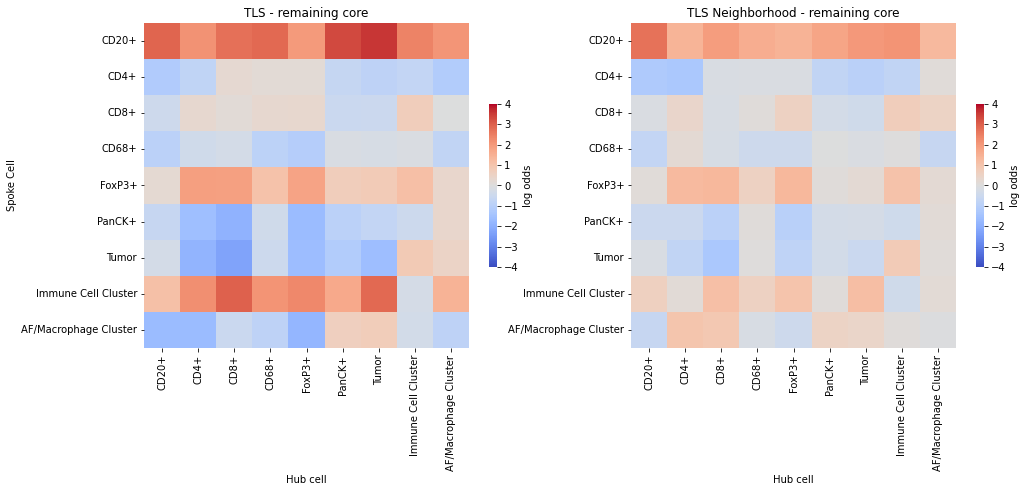

In [105]:
fig = plt.figure(figsize=(16,6))
i = 1
non_tls = delHelpers.generate_log_odds_matrix(keep_cx[2],
                             cell_names,
                             tissue_types,
                             version = 2)
kout = []
for lab,connections in zip(labs[0:2], keep_cx[0:2]):
    ax = fig.add_subplot(1,2,i,aspect='equal')
    output = delHelpers.generate_log_odds_matrix(connections,
                                 cell_names,
                                 tissue_types,
                                 version =2 )
    kout.append(output)
    ax = delPlots.connection_heatmap(output-non_tls, 
                                     cell_names,
                                     ax = ax,
                                     vmin = -4,
                                     vmax = 4,
                                     label = 'log odds'
                                    )
    ax.set_title(lab + ' - remaining core')
    if i > 1:
        ylabel=''
    else:
        ylabel = 'Spoke Cell'
    ax.set_ylabel(ylabel)
    i = i + 1
print('Finished')
print('%s seconds' % (time.time()-start))

Text(0.5, 1.0, 'TLS - Neighborhood')

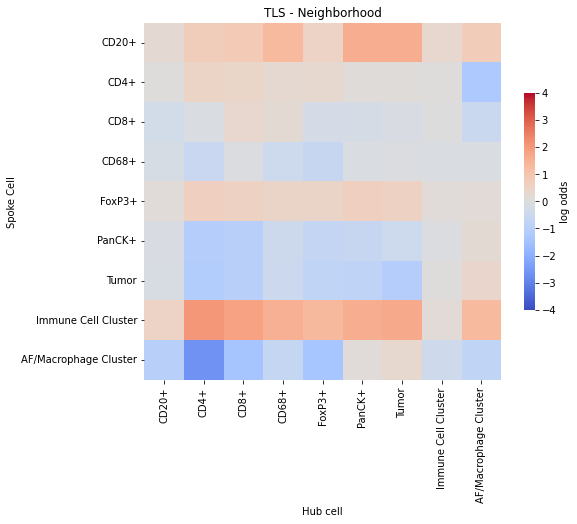

In [79]:
ax = delPlots.connection_heatmap(kout[0]-kout[1], 
                                 cell_names,
                                 vmin = -4,
                                 vmax = 4,
                                 label = 'log odds'
                                )
ax.set_title('TLS - Neighborhood')

# 1) (run sbatch) --> Identify jobs dropped by sbatch

In [25]:
# a=pd.read_csv('/ix/rbao/Projects/HCC-CBS-028-Pfizer-TBruno/logs/batch_delaunay/v7.qc0.nr200um.cd20-1000.mincd20-15.ct-14/v1/proc_times.csv',sep=':',header=None)
a=pd.read_csv('/ix/rbao/Projects/HCC-CBS-028-Pfizer-TBruno/logs/batch_delaunay/v7.qc0.nr200um.cd20-1000.mincd20-15.ct-14/v2/proc_times.csv',sep=':',header=None)
p=a.loc[:,0]
ii=[]
for log in p:
    ii.append(int(log.split('_')[1].split('.')[0]))
j = 1
diffs = np.diff(np.sort(ii))
keep = []
for i in np.argwhere(diffs>1):
    print(i[0] + j)
    keep.append(str(i[0]+j))
    j = j + diffs[i[0]] - 1
print(','.join(keep))                

29
238
29,238


# 2) Load in each TLS-centric DV network analysis file, if any, generate output, add to stack,save

In [2]:
cxpn = results.joinpath('neighborhoods/v7.qc0.nr200um.cd20-1000.mincd20-15.ct-14/v2') # version 2 has tls_id in spreadsheet
cxfns = cxpn.glob('*tls.csv')
tls_fns = np.sort([fn for fn in cxfns])

cxfns = cxpn.glob('*tlsneighbors.csv')
tls_neigh_fns = np.sort([fn for fn in cxfns])

cxfns = cxpn.glob('*remaining_core.csv')
rem_core_fns = np.sort([fn for fn in cxfns])

print(tls_fns[0].parts[-1])
print(tls_neigh_fns[0].parts[-1])
print(rem_core_fns[0].parts[-1])

# fns = [Path('/mnt/results/neighborhoods/v7.qc0.nr200um.cd20-1000.mincd20-15.ct-14/v1/85_TMA01_Core[1,4,R]_delaunay_cx_tls.csv')]
good_tls = []
print(len(tls_fns))
start = time.time()
outs = {'tls':[],'tls_neigh':[],'rem_core':[]}
labs = list(outs.keys())
tls_keep = []
tls_tma_codes = []
for flist in zip(tls_fns,tls_neigh_fns,rem_core_fns):
    for i,f in enumerate(flist):
        connections = pd.read_csv(f)
        if (i == 0) and (connections.shape[0] > 0):     
            notna = ~connections['tls_id'].isna()
            tls_ids = np.unique(connections.loc[notna,'tls_id'].values)
            good_tls.append(tls_ids)
            loc_keep=[]
            for tls_id in tls_ids:
                idx = connections.loc[:,'tls_id'].values == tls_id
                output = delHelpers.generate_log_odds_matrix(connections.loc[idx,:],
                         cell_names,
                         tissue_types,
                         version =2 )
                output[np.isinf(output)]= np.nan
                tls_keep.append(output)
                loc_keep.append(output)
                tls_tma_codes.append('_'.join(f.parts[-1].split('_')[1:3] + ['tls',str(int(tls_id)-1)]))
            outs[labs[i]].append(loc_keep)
        else:
            good_tls.append([np.nan])    
            output = delHelpers.generate_log_odds_matrix(connections,
                                     cell_names,
                                     tissue_types,
                                     version =2 )
            output[np.isinf(output)]= np.nan
            outs[labs[i]].append(output)
stop = time.time()
print(stop-start,"seconds")

0_TMA01_Core[1,1,C]_delaunay_cx_tls.csv
0_TMA01_Core[1,1,C]_delaunay_cx_tlsneighbors.csv
0_TMA01_Core[1,1,C]_delaunay_cx_remaining_core.csv
304
117.51135540008545 seconds


Text(849.9882352941178, 0.5, '')

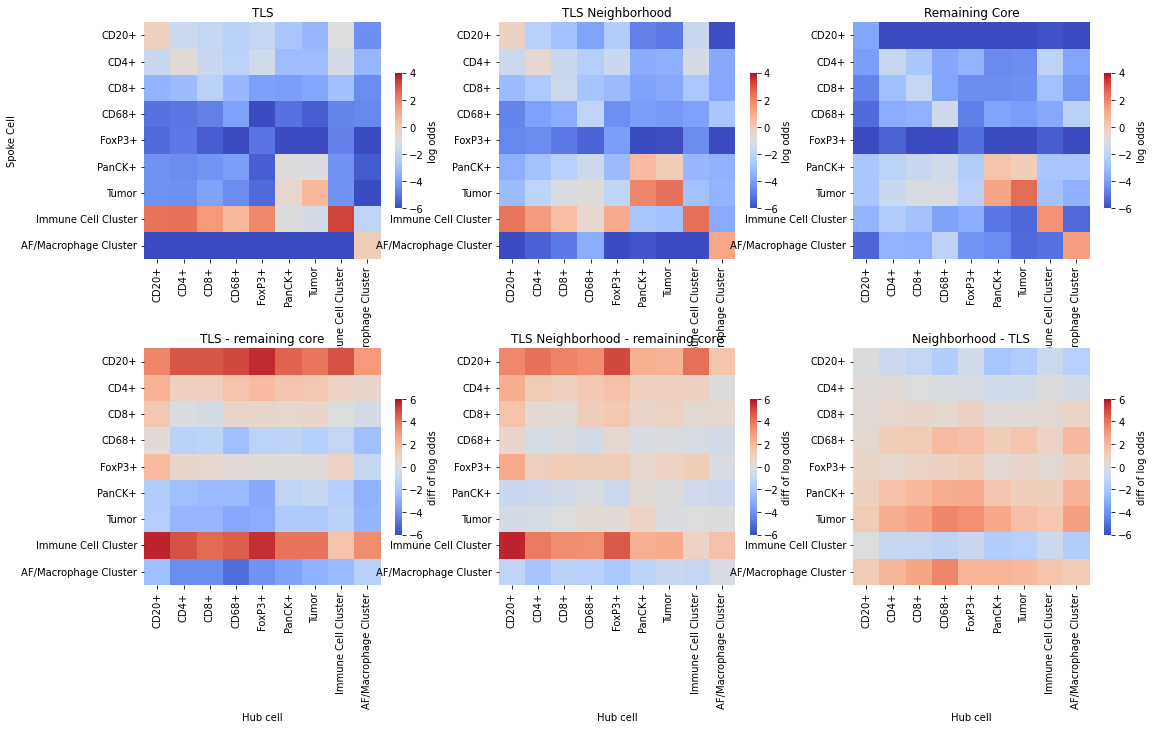

In [13]:
fig = plt.figure(figsize=[18,11],)
labs = ['TLS', 'TLS Neighborhood','Remaining Core']
i = 1   
out_stack = []
for lab,key in zip(labs,outs.keys()):
    ax = fig.add_subplot(2,len(labs),i,aspect='equal')    
    if key == 'tls':
        delcx = np.nanmean(np.stack(tls_keep),axis=0)
    else:
        delcx = np.nanmean(np.stack(outs[key]),axis=0)
    ax = delPlots.connection_heatmap(delcx,
                                         cell_names,
                                         ax = ax,
                                         vmin = -6,
                                         vmax = 4,
                                         label = 'log odds'
                                        )
    out_stack.append(delcx)
    ax.set_title(lab)
    if i > 1:
        ylabel=''
    else:
        ylabel = 'Spoke Cell'
    ax.set_ylabel(ylabel)
    i = i + 1
non_tls = out_stack[2]
for lab,delcx in zip(labs[0:2], out_stack[0:2]):
    ax = fig.add_subplot(2,len(labs),i,aspect='equal')         
    ax = delPlots.connection_heatmap(delcx-non_tls, 
                                     cell_names,
                                     ax = ax,
                                     vmin = -6,
                                     vmax = 6,
                                     label = 'diff of log odds'
                                    )
    ax.set_title(lab + ' - remaining core')
    if i > 1:
        ylabel=''
    else:
        ylabel = 'Spoke Cell'
    ax.set_ylabel(ylabel)
    i = i + 1

# Lastly add TLS - Neighborhood:
ax = fig.add_subplot(2,len(labs),i,aspect='equal')
ax = delPlots.connection_heatmap(out_stack[1]-out_stack[0], 
                                 cell_names,
                                 vmin = -6,
                                 vmax = 6,
                                 ax = ax,
                                 label = 'diff of log odds'
                                )
ax.set_title('Neighborhood - TLS')   
ax.set_ylabel('')
            

# 3) Load in data to map connections to previously calculated TLS types

In [3]:
cxpn = results.joinpath('neighborhoods/v7.qc0.nr200um.cd20-1000.mincd20-15.ct-14/v2') # version 2 has tls_id in spreadsheet
cxfns = cxpn.glob('*tls.csv')
tls_fns = np.sort([fn for fn in cxfns])
tls_fns = [str(fn.parts[-1]) for fn in tls_fns]
all_core_codes = []
for fn in tls_fns:
    temp = fn.split('_delaunay_cx_tls.csv')[0]
    all_core_codes.append('_'.join(temp.split('_')[1:]))
    
# all_core_codes = tls.seg_fn_to_unique_tma_code(tls_fns)
clin_version = 4
tls_full = pd.read_pickle('/mnt/results/all_tls_features_with_clinical_UMAP_size_and_pattern_clinv%d.pkl' % clin_version)
missing = tls_full['missing_data'].values
tma_id = np.unique(tls_full.loc[~missing,'unique_TMA_Code'])
k_tid = []
for tid in tls_full['tls_id']:
    newid ='_'.join(tid.split('_')[0:2] + ['tls',tid.split('_')[-1]])
    k_tid.append(newid)

cxn_tls_tma = tls_tma_codes    
n_tma = len(tma_id)
has_tls = ~ (tls_full['tls_id'].values == "None")
good_tls = tls_full['tls_is_good'].values
use_tls =  good_tls
idx = tls_full.loc[use_tls,'unique_TMA_Code'].isin(all_core_codes)

print('Unique TLS found in cores n =',np.sum(idx.values), 'out of', np.sum(good_tls))
tls_cores = np.unique(tls_full.loc[use_tls,'unique_TMA_Code'].values)
print('Unique cores in TLS n =', len(tls_cores))
tls_core_idx = pd.Series(all_core_codes).isin(tls_cores).values
print('Unique TLS cores found in all cores n =' ,np.sum(tls_core_idx))




Unique TLS found in cores n = 163 out of 163
Unique cores in TLS n = 90
Unique TLS cores found in all cores n = 90


# 4) Align tls_full with delaunay TLS connection plots

In [4]:
org = {}

tls_cores = np.unique(tls_full.loc[use_tls,'unique_TMA_Code'].values)
org2={}
matched=[]
tls_full_id = []
patterns={}
sizes={}
for core in tls_cores:
    core_idx = tls_full.loc[:,'unique_TMA_Code'] == core
    tot = core_idx & use_tls & ~missing
    
    core_tls_ids = tls_full.loc[tot,'tls_id'].values
    pattern_types = tls_full.loc[tot ,'pattern_based_UMAP_cluster_ids'].values
    size_types = tls_full.loc[tot, 'size_based_UMAP_cluster_ids'].values
    i = 0
    for tls_id in core_tls_ids:
        tls_num = tls_id.split('_')[-1]
        key = '_'.join(tls_id.split('_')[0:2])
        if key in org2.keys():
            org2[key] =  org2[key] + [tls_id.split('_')[-1]]
            patterns[key] = patterns[key] + [pattern_types[i]]
            sizes[key] =  sizes[key] + [size_types[i]]
        else:
            org2[key] =   [tls_id.split('_')[-1]]  
            patterns[key] =  [pattern_types[i]]
            sizes[key] =   [size_types[i]]
        tls_full_id.append(key + tls_id.split('_')[-1])
        i = i + 1
            
sorted_codes = tls_tma_codes
i = 0
for code in sorted_codes :
    key = '_'.join(code.split('_')[0:2])    
    if key in org.keys():
        org[key] =  org[key] + [int(code.split('_')[-1])] 
    else:
        org[key] =  [int(code.split('_')[-1])] 
        
    i = i + 1
print(len(org.keys()),i)
# print(org)

# for key1,key2 in zip(org.keys(),org2.keys()):
#     if not (len(org[key1]) == len(org2[key2])):
#         print(key1,key2)
dat1=np.stack(([str(x) for x in org.keys()],
               [v for v in org.values()])).T
dat2=np.stack(([str(x) for x in org2.keys()],
               [v for v in org2.values()])).T

sizedat = np.stack(([str(x) for x in sizes.keys()],
               [v for v in sizes.values()])).T
patdat = np.stack(([str(x) for x in patterns.keys()],
               [v for v in patterns.values()]),).T

dfcx = pd.DataFrame(data=dat1, columns=['tma_id','tls_num'],)
dffull = pd.DataFrame(data=dat2, columns = ['tma_id','tls_num'])
patdf = pd.DataFrame(data=patdat,  columns = ['tma_id','tls_pattern_type'])
sizedf = pd.DataFrame(data=sizedat,  columns = ['tma_id','tls_size_type'])


m = pd.merge(dfcx,dffull,how='right',on='tma_id')
m = pd.merge(patdf,m,how='right',on='tma_id')
m = pd.merge(sizedf,m,how='right',on='tma_id')
m.head()


91 168


/opt/conda/envs/py38/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


,tma_id,tls_size_type,tls_pattern_type,tls_num_x,tls_num_y
0,"TMA01_Core[1,1,G]",[4.0],[5.0],[0],[1]
1,"TMA01_Core[1,1,Q]","[4.0, 2.0]","[2.0, 3.0]","[0, 1]","[2, 4]"
2,"TMA01_Core[1,1,R]","[2.0, 0.0, 3.0]","[3.0, 3.0, 0.0]","[0, 1, 2]","[0, 1, 2]"
3,"TMA01_Core[1,10,C]","[4.0, 0.0]","[1.0, 0.0]","[0, 1]","[0, 1]"
4,"TMA01_Core[1,10,D]",[4.0],[2.0],[0],[0]


# Plot average log odd connectivity for each TLS type:

In [5]:
print(len(tls_tma_codes),len(tls_keep))
print(tls_tma_codes[0])

168 168
TMA01_Core[1,5,R]_tls_0


In [5]:
def gather_cx(cx_tls_list,
              cx_tls_codes,
              merged_df,
              type_num,
              type_col = 'tls_pattern_type'):
    use = []
    for core in merged_df['tma_id']:
        idx = merged_df['tma_id'].isin([core])
        core_types = merged_df.loc[idx, type_col].values[0]
        cx_tls_nums = merged_df.loc[idx,'tls_num_x'].values[0]
        for type_id,tls_id in zip(core_types,cx_tls_nums):
            if type_id == type_num:
                base_name = core + '_tls_' + str(tls_id)  
                use.append(base_name)
    # use = np.array(use)
    idx = pd.Series(cx_tls_codes).isin(use)
    return np.array(tls_keep)[idx,:,:]
test = gather_cx( tls_keep, tls_tma_codes, m, 1)
test.shape

(36, 9, 9)

# Plot connections by TLS pattern type (from earlier 02_generate_pattern... umaps)

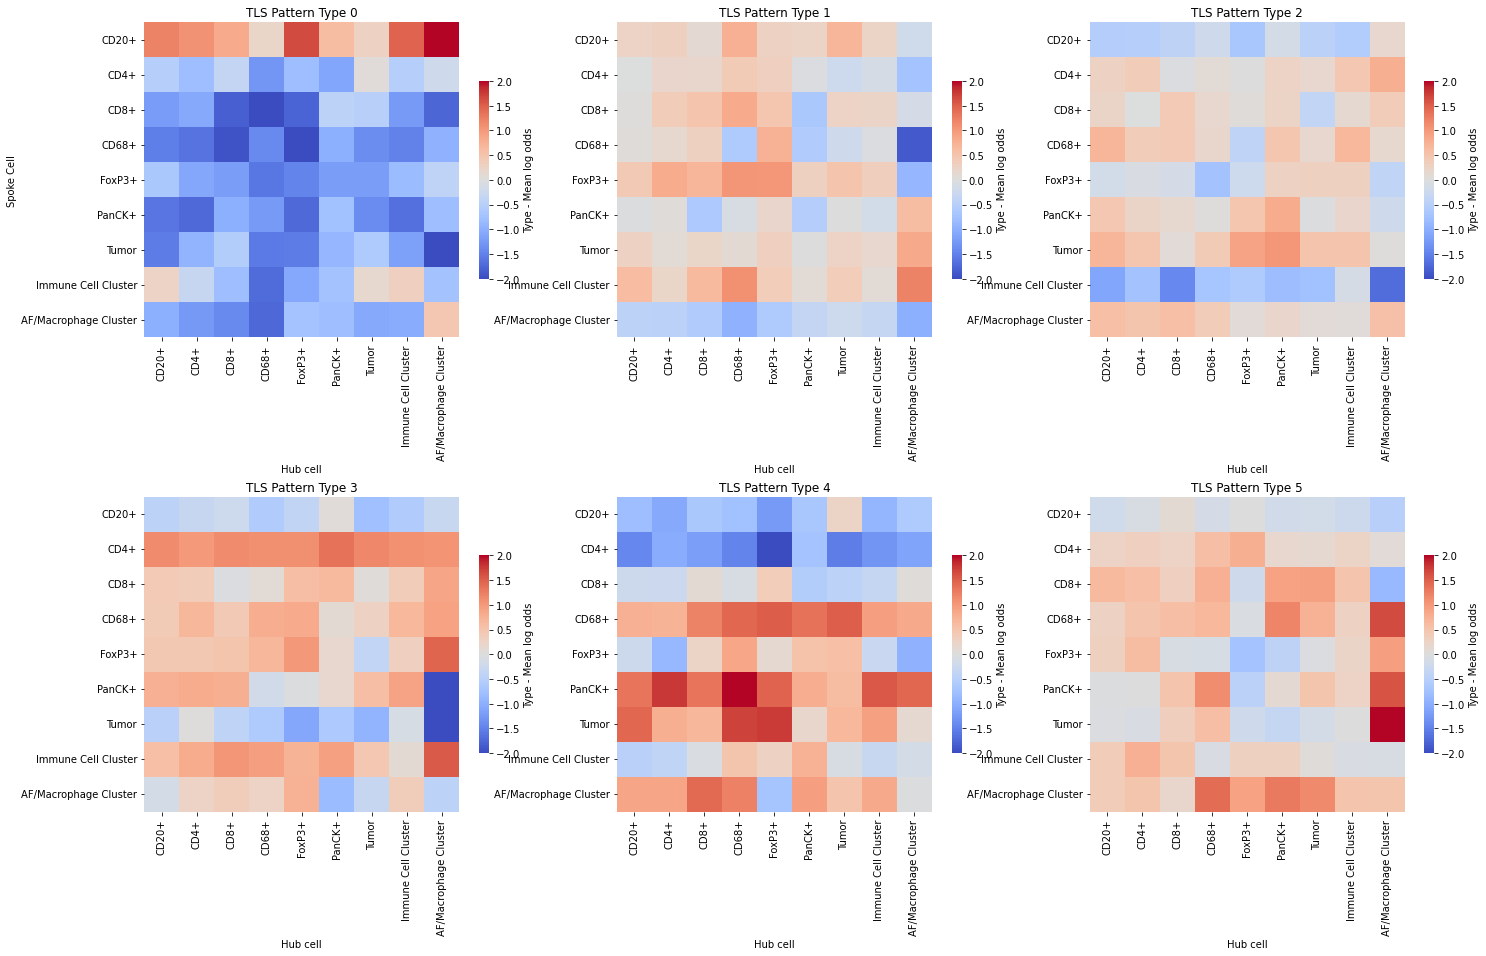

In [18]:
fig = plt.figure(figsize=[24,16],)
mean_tls = np.nanmean(np.array(tls_keep),axis=0)

types = [x for x in range(0,6)]
for tls_type in types:
    cx=gather_cx(tls_keep, tls_tma_codes, m, 
              tls_type,
              type_col = 'tls_pattern_type')
    ax = fig.add_subplot(2,3,tls_type+1,aspect='equal')         
    ax = delPlots.connection_heatmap(np.nanmean(cx,axis=0) - mean_tls, 
                                     cell_names,
                                     ax = ax,
                                     vmin = -2,
                                     vmax = 2,
                                     label = 'Type - Mean log odds'
                                    )
    ax.set_title('TLS Pattern Type %d' % tls_type)
    if tls_type > 0:
        ylabel=''
    else:
        ylabel = 'Spoke Cell'
    # if tls_type < 3:
    #     ax.set_xticks([])
    #     ax.set_xlabel('')
        
    ax.set_ylabel(ylabel)
    
    
    

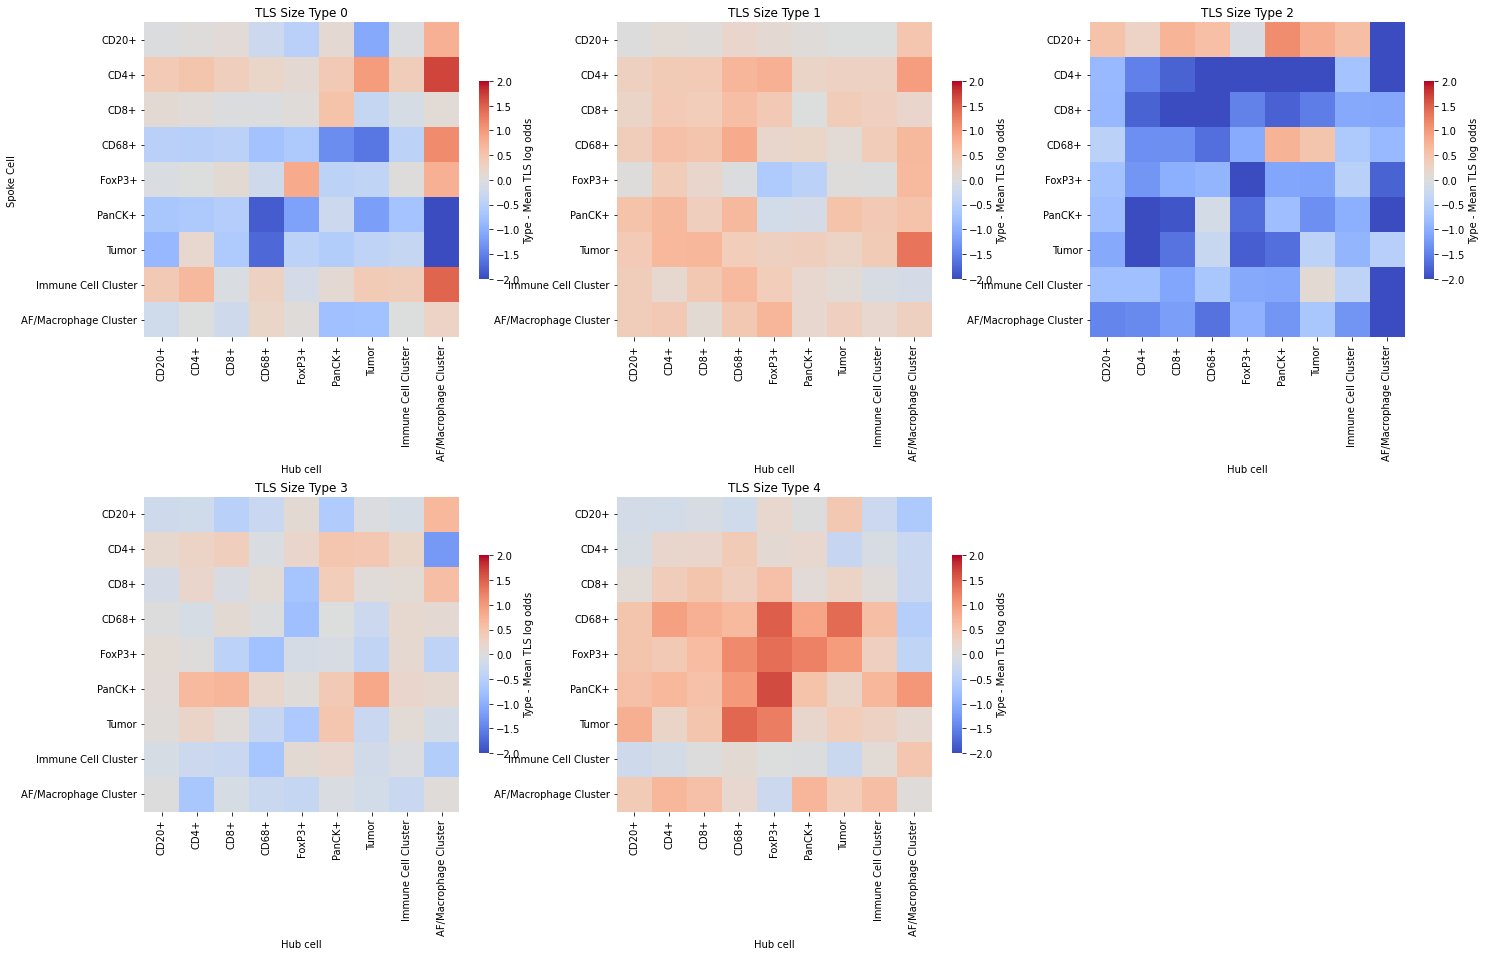

In [19]:
fig = plt.figure(figsize=[24,16],)
types = [x for x in range(0,5)]
mean_tls = np.nanmean(np.array(tls_keep),axis=0)

for tls_type in types:
    cx=gather_cx(tls_keep, tls_tma_codes, m, 
              tls_type,
              type_col = 'tls_size_type')
    ax = fig.add_subplot(2,3,tls_type+1,aspect='equal')         
    ax = delPlots.connection_heatmap(np.nanmean(cx,axis=0) - mean_tls, 
                                     cell_names,
                                     ax = ax,
                                     vmin = -2,
                                     vmax = 2,
                                     label = 'Type - Mean TLS log odds'
                                    )
    ax.set_title('TLS Size Type %d' % tls_type)
    if tls_type > 0:
        ylabel=''
    else:
        ylabel = 'Spoke Cell'
    # if tls_type < 3:
        # ax.set_xticks([])
        # ax.set_xlabel('')
        
    ax.set_ylabel(ylabel)
    

# Plot size TLS connectivity, combining 2 small sizes and 2 intermediate sizes:

54


/opt/conda/envs/py38/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,tma_id,tls_size_type,tls_pattern_type,tls_num_x,tls_num_y,coarse_tls_size,tls_size_remapped,coarse_tls_size_num
0,"TMA01_Core[1,1,G]",[4.0],[5.0],[0],[1],large,[4],[3]
1,"TMA01_Core[1,1,Q]","[4.0, 2.0]","[2.0, 3.0]","[0, 1]","[2, 4]",inter,"[4, 0]","[2, 2]"
2,"TMA01_Core[1,1,R]","[2.0, 0.0, 3.0]","[3.0, 3.0, 0.0]","[0, 1, 2]","[0, 1, 2]",small,"[0, 2, 1]","[1, 1, 1]"
3,"TMA01_Core[1,10,C]","[4.0, 0.0]","[1.0, 0.0]","[0, 1]","[0, 1]",inter,"[4, 2]","[2, 2]"
4,"TMA01_Core[1,10,D]",[4.0],[2.0],[0],[0],large,[4],[3]


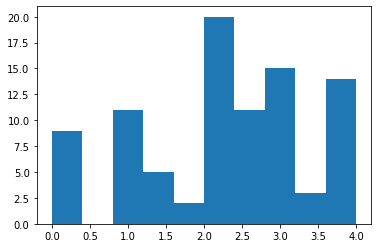

In [15]:
remap = [2,3,0,1,4]
means = []
mapped = []
size_num = []
for i in range(0,m.shape[0]):
    tls_sizes = np.array(m.loc[i,'tls_size_type']).astype(int)
    remapped = [remap[x] for x in tls_sizes]
    mapped.append(remapped)
    # m.loc[i,'tls_mean_size'] = np.mean(remapped)
    # print(i,tls_sizes,remapped,np.mean(remapped))
    means.append(np.mean(remapped))
    mm = np.mean(remapped)
    if (mm > 1) & (mm <3.5):
        sss = 2
    elif (mm <=1):
        sss = 1
    else:
        sss = 3
    size_num.append([sss]*len(remapped))
    # mean_size = np.mean(remapped)
means = np.array(means)
plt.hist(means)
inter = (means > 1) & (means < 3.5)
small = (means <=1)
large = (means >= 3.5)
print(np.sum(inter))
m.loc[small,'coarse_tls_size'] = 'small'
m.loc[inter,'coarse_tls_size'] = 'inter'
m.loc[large,'coarse_tls_size'] = 'large'
m.loc[:,'tls_size_remapped']= mapped
m.loc[:,'coarse_tls_size_num']=size_num
m.head()
# .loc[m.tls_size_type.isin([0,1]),'coarse_tls_size_type'] = 'Inter'
# m.head()

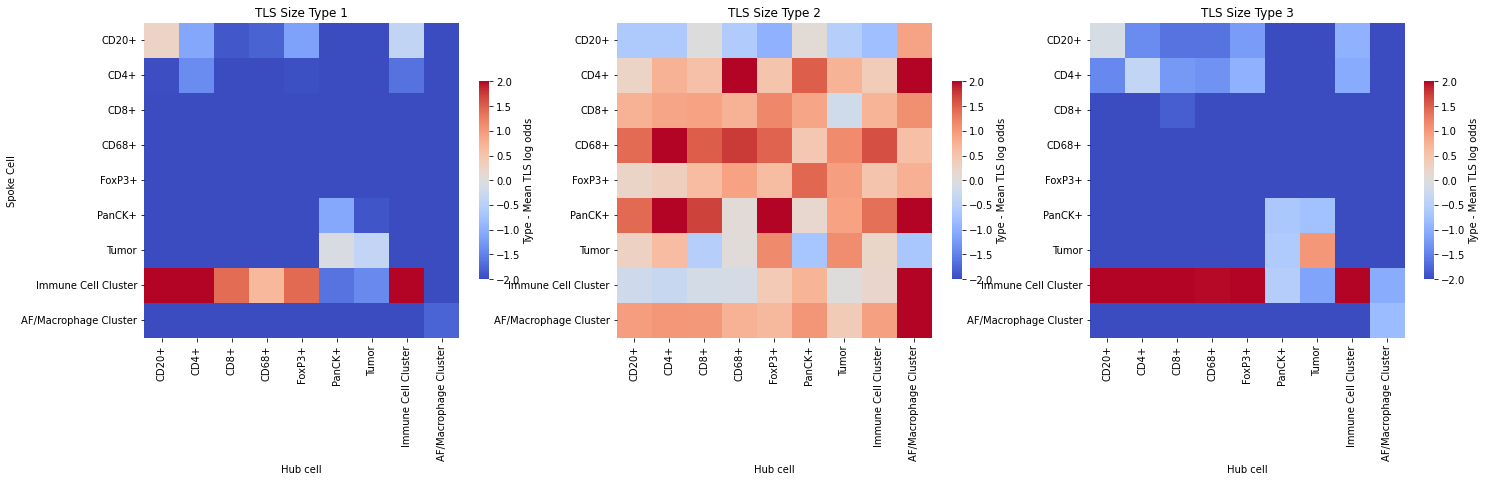

In [20]:
fig = plt.figure(figsize=[24,16],)

types = [1,2,3]
mean_tls = np.nanmean(np.array(tls_keep),axis=0)

for i,tls_type in enumerate(types):
    cx=gather_cx(tls_keep, tls_tma_codes, m, 
              tls_type,
              type_col = 'coarse_tls_size_num')
    ax = fig.add_subplot(2,3,i+1,aspect='equal')      
    mm = np.nanmean(cx,axis=0) 
    
    if i == 0: 
        prev = mm
    elif i == 1:
        mm = mm - prev
    else:
        mm = mm 
    ax = delPlots.connection_heatmap(mm, 
                                     cell_names,
                                     ax = ax,
                                     vmin = -2,
                                     vmax = 2,
                                     label = 'Type - Mean TLS log odds'
                                    )
    ax.set_title('TLS Size Type %s' % tls_type)
    if i > 0:
        ylabel=''
    else:
        ylabel = 'Spoke Cell'
    # if tls_type < 3:
        # ax.set_xticks([])
        # ax.set_xlabel('')
        
    ax.set_ylabel(ylabel)
    

# TLS connectivity UMAP

In [39]:
np.nanmean(dat.reshape(-1,1))

-3.5746384123484707

(168, 81)

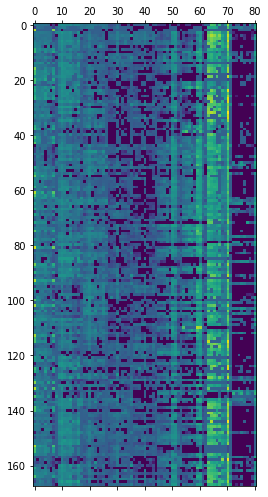

In [48]:
dat = np.stack(tls_keep)
dat = np.reshape(dat,(dat.shape[0],dat.shape[1]*dat.shape[2]))
isnan = np.isnan(dat)
dat[isnan]=np.nanmean(dat.reshape(-1,1))
dat = normalize(dat, norm= 'max', axis = 0)
plt.matshow(dat)
# dat = np.moveaxis(dat,[0,1,2],[2,0,1])
dat.shape

Text(0, 0.5, 'UMAP 1')

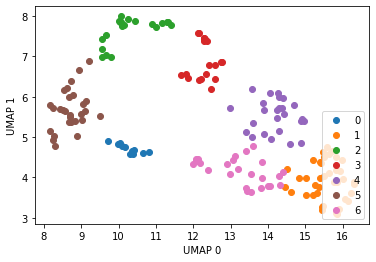

In [44]:
method = 'UMAP'
n_comp = 2
metric = 'l1' # 'euclidean'
n_clust = 7
if method == 'UMAP':
    fit = umap.UMAP(n_neighbors = 10,
                    min_dist = 0.01,
                    n_components = n_comp,
                    metric = metric, #metric, #Euclidean  mahalanobis
                    init = 'spectral',
                   random_state = 42)
    
u = fit.fit_transform(dat)
km = KMeans(n_clusters = n_clust,            
           random_state = 42)
km.fit(u)

ids = km.labels_
h = []

for uid in np.unique(ids):
    idx = ids == uid
    plt.scatter(u[idx,0], u[idx,1], label=str(uid))
plt.legend(loc='lower right')
plt.xlabel('UMAP 0')
plt.ylabel('UMAP 1')

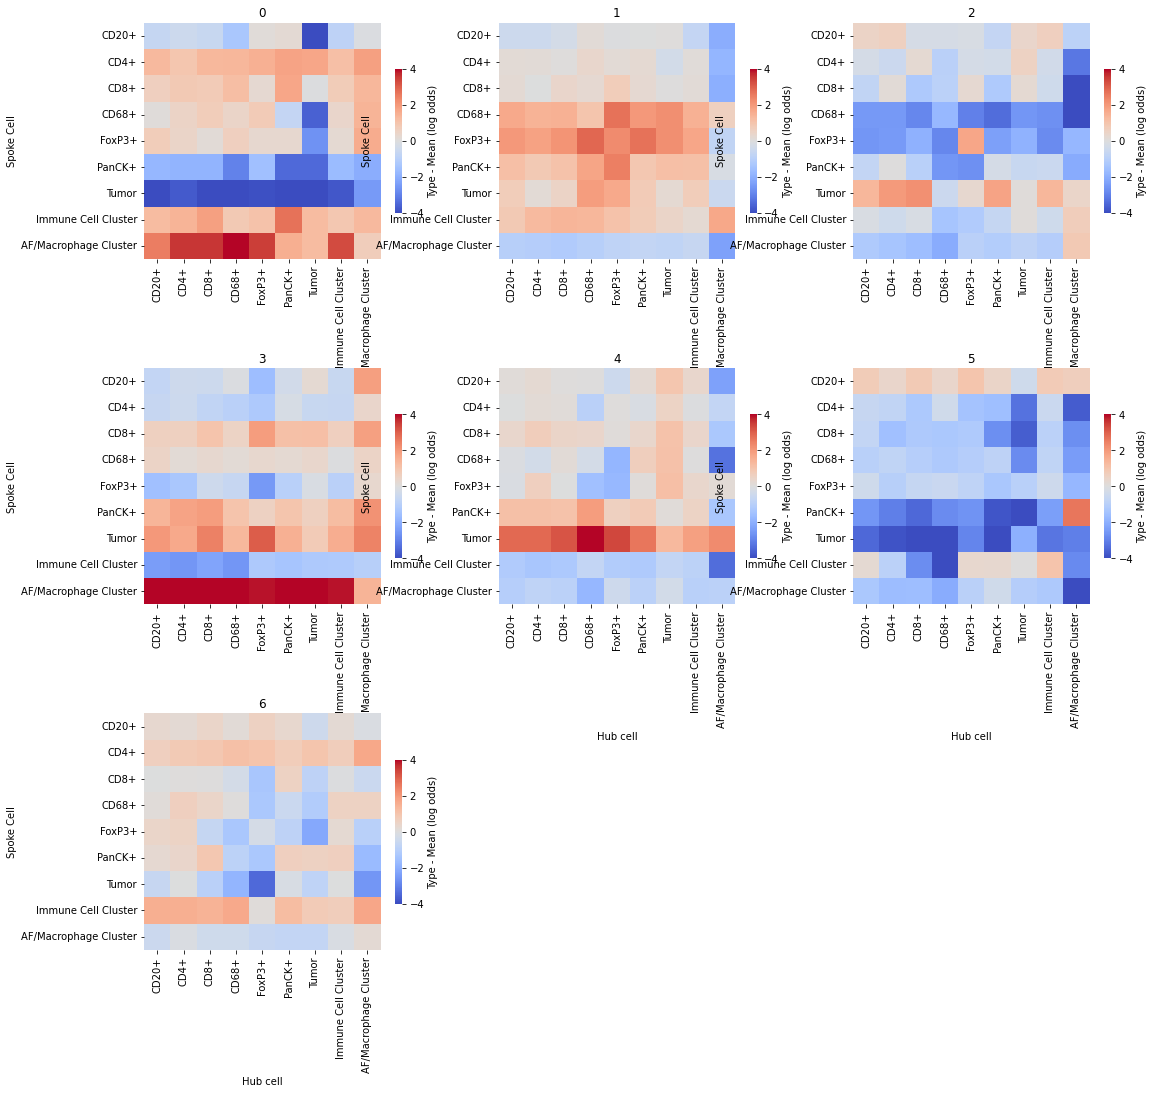

In [49]:
fig = plt.figure(figsize=[18,18],)
i = 1   
tls = np.stack(tls_keep)
all_tls = np.nanmean(tls,axis=0)
for uid in np.unique(ids):
    idx = ids == uid
    delcx = np.nanmean(tls[idx,:,:],axis=0)
    ax = fig.add_subplot(3,3,i,aspect='equal')         
    ax = delPlots.connection_heatmap(delcx - all_tls,
                                     cell_names,
                                     ax = ax,
                                     vmin = -4,
                                     vmax = 4,
                                     label = 'Type - Mean (log odds)'
                                    )
    i = i + 1
    ax.set_title(uid)